# CRISPDM Framework

Image source: ftp://public.dhe.ibm.com/software/analytics/spss/documentation/modeler/18.0/en/ModelerCRISPDM.pdf

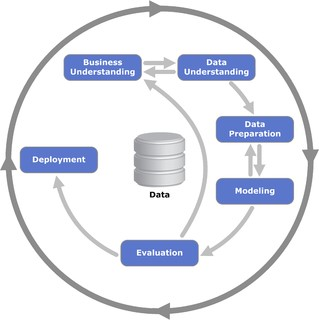

## Data Understanding

https://www.kaggle.com/datasets/airbnb/seattle

https://www.kaggle.com/datasets/airbnb/boston

The following Airbnb activity is included in this dataset:<br>

1. Listings, including full descriptions and average review score
2. Reviews, including unique id for each reviewer and detailed comments
3. Calendar, including listing id and the price and availability for that day

### Import Library

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import pygwalker as pyg
import matplotlib.pyplot as plt
import sweetviz as sv
from io import StringIO
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

### Download Dataset

In [ ]:
!kaggle datasets download -d airbnb/seattle
!kaggle datasets download -d airbnb/boston

!unzip seattle.zip
!unzip boston.zip

### Reading Dataset

In [2]:
def flag_city(df,city):
    df["city"]=city
    return df

def concat(df1,df2):
    return pd.concat([df1[df1.columns], df2[df1.columns]])

def to_date(df,columns):
    for col in columns:
        df[col] = pd.to_datetime(df[col]).dt.strftime('%Y-%m-%d')
    return df

def price_to_numeric(df,columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col].str.replace('$', '').str.replace(',', ''))
    return df

In [115]:
calendar_dtype = {'listing_id': str}
listing_dtype = {"id": str,"hos_id": str}
reviews_dtype = {"id": str, 'listing_id': str,'reviewer_id': str}


seattle_calendar = flag_city(pd.read_csv("./seattle/calendar.csv",dtype= calendar_dtype),"Seattle")
seattle_listings = flag_city(pd.read_csv("./seattle/listings.csv",dtype= listing_dtype),"Seattle")
seattle_reviews = flag_city(pd.read_csv("./seattle/reviews.csv",dtype= reviews_dtype),"Seattle")

boston_calendar = flag_city(pd.read_csv("./boston/calendar.csv",dtype= calendar_dtype),"Boston")
boston_listings = flag_city(pd.read_csv("./boston/listings.csv",dtype= listing_dtype),"Boston")
boston_reviews = flag_city(pd.read_csv("./boston/reviews.csv",dtype= reviews_dtype),"Boston")

In [116]:
calendar = pd.concat([seattle_calendar, boston_calendar])
calendar = to_date(calendar,["date"])
calendar = price_to_numeric(calendar,["price"])

listings = pd.concat([seattle_listings, boston_listings])
listings = to_date(listings,["host_since","first_review","last_review"])
listings = price_to_numeric(listings,["price","weekly_price","monthly_price","cleaning_fee"])

reviews = pd.concat([seattle_reviews, boston_reviews])
reviews = to_date(reviews,["date"])

In [45]:
print(f"""
    Seattle Data
    Number of observation: {np.shape(calendar[calendar["city"]=="Seattle"])[0]} records
    Fist observation: {str(calendar[calendar["city"]=="Seattle"]["date"].min())}
    Last observation: {str(calendar[calendar["city"]=="Seattle"]["date"].max())}
    
    Total Host: {np.shape(listings[listings["city"]=="Seattle"]["host_id"].unique())[0]}
    Total Listing: {np.shape(listings[listings["city"]=="Seattle"]["id"].unique())[0]}

""")


print(f"""
    Boston Data
    Number of observation: {np.shape(calendar[calendar["city"]=="Boston"])[0]} records
    Fist observation: {str(calendar[calendar["city"]=="Boston"]["date"].min())}
    Last observation: {str(calendar[calendar["city"]=="Boston"]["date"].max())}
    
    Total Host: {np.shape(listings[listings["city"]=="Boston"]["host_id"].unique())[0]}
    Total Listing: {np.shape(listings[listings["city"]=="Boston"]["id"].unique())[0]}
""")


    Seattle Data
    Number of observation: 1393570 records
    Fist observation: 2016-01-04
    Last observation: 2017-01-02
    
    Total Host: 2751
    Total Listing: 3818



    Boston Data
    Number of observation: 1308890 records
    Fist observation: 2016-09-06
    Last observation: 2017-09-05
    
    Total Host: 2181
    Total Listing: 3585



### EDA

In [12]:
analyze_report = sv.analyze(calendar)
analyze_report.show_html("calendar.html",open_browser=True)

In [13]:
analyze_report = sv.analyze(listings)
analyze_report.show_html("listings.html",open_browser=True)

In [14]:
analyze_report = sv.analyze(reviews)
analyze_report.show_html("reviews.html",open_browser=True)

#### How is property distribution listed in Seattle compared to Boston?

In [46]:
import plotly.figure_factory as ff

df = listings[listings["price"]<1500]

hist_data = [df[df["city"]=="Boston"]["price"], df[df["city"]=="Seattle"]["price"]]

group_labels = ['Boston', 'Seattle']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(
    hist_data, group_labels,
    show_hist=False,
)

fig.update_layout(title_text='Listing Price Distribution',template='simple_white',xaxis_title="Price",)
fig.show()

### Is there any pricing difference for particular property type between those cities?

In [100]:
import plotly.express as px
from plotly.subplots import make_subplots

df_seattle = listings[listings["city"]=="Seattle"]
df_seattle = (
    df_seattle[["city","property_type","id","price"]]
    .groupby(['city','property_type'])
    .agg({'id':'size', 'price':'mean'}) 
    .reset_index()
).sort_values(by='id', ascending=True)

# Create distplot with curve_type set to 'normal'
fig_seattle = px.bar(df_seattle,
             y="property_type", x="id",color="price",text="price",
             orientation='h'
).update_layout(
    title_text='Seattle Property Type',template='simple_white',
    yaxis={'categoryorder':'total ascending'},
    yaxis_title="Property Type",
    xaxis_title="Number of Listing",
).update_traces(texttemplate='%{text:.2s}')

df_boston = listings[listings["city"]=="Boston"]
df_boston = (
    df_boston[["city","property_type","id","price"]]
    .groupby(['city','property_type'])
    .agg({'id':'size', 'price':'mean'}) 
    .reset_index()
).sort_values(by='id', ascending=True)

# Create distplot with curve_type set to 'normal'
fig_boston = px.bar(df_boston,
             y="property_type", x="id",color="price",text="price",
             orientation='h'
).update_layout(
    title_text='Boston Property Type',template='simple_white',
    yaxis={'categoryorder':'total ascending'},
    yaxis_title="Property Type",
    xaxis_title="Number of Listing",
).update_traces(texttemplate='%{text:.2s}')

figure1_traces = []
figure2_traces = []

for trace in range(len(fig_seattle["data"])):
    figure1_traces.append(fig_seattle["data"][trace])
for trace in range(len(fig_boston["data"])):
    figure2_traces.append(fig_boston["data"][trace])

fig_subplot = make_subplots(rows=1, cols=2, subplot_titles=('Seattle',  'Boston'))
for traces in figure1_traces:
    fig_subplot.append_trace(traces, row=1, col=1)
for traces in figure2_traces:
    fig_subplot.append_trace(traces, row=1, col=2)

fig_subplot.update_layout(
    title_text='Property Type (color indicate price)',template='simple_white',
    yaxis_title="Property Type",
    xaxis_title="Number of Listing",
    showlegend=True,
).update_traces(texttemplate='%{text:.2s}')

fig_subplot['layout']['xaxis']['title']='Number of Listing'
fig_subplot['layout']['xaxis2']['title']='Number of Listing'

fig_subplot.show()

### How is the average rating differ between those cities, by property type?

In [55]:
import plotly.figure_factory as ff

df = listings[(listings["review_scores_rating"].notnull()) & (listings["review_scores_rating"]> 50)]

hist_data = [df[df["city"]=="Boston"]["review_scores_rating"], df[df["city"]=="Seattle"]["review_scores_rating"]]

group_labels = ['Boston', 'Seattle']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(
    hist_data, group_labels,
    show_hist=False,
)

fig.update_layout(title_text='Overall Rating Distribution',template='simple_white',xaxis_title="Review Score",)
fig.show()

In [109]:
import plotly.express as px
from plotly.subplots import make_subplots

df_seattle = listings[listings["city"]=="Seattle"]
df_seattle = (
    df_seattle[["city","property_type","id","review_scores_rating","number_of_reviews"]]
    .groupby(['city','property_type'])
    .agg({'id':'size', 'review_scores_rating':'mean',"number_of_reviews": "sum"}) 
    .reset_index()
).sort_values(by='review_scores_rating', ascending=True)

# Create distplot with curve_type set to 'normal'
fig_seattle = px.bar(df_seattle,
             y="property_type", x="review_scores_rating",color="number_of_reviews",text="review_scores_rating",
             orientation='h'
).update_layout(
    title_text='Seattle Property Type',template='simple_white',
    yaxis={'categoryorder':'total ascending'},
    yaxis_title="Property Type",
    xaxis_title="Number of Listing",
).update_traces(texttemplate='%{text:.2s}')

df_boston = listings[listings["city"]=="Boston"]
df_boston = (
    df_boston[["city","property_type","id","review_scores_rating","number_of_reviews"]]
    .groupby(['city','property_type'])
    .agg({'id':'size', 'review_scores_rating':'mean',"number_of_reviews": "sum"}) 
    .reset_index()
).sort_values(by='review_scores_rating', ascending=True)
df_boston = df_boston[df_boston["review_scores_rating"].notnull()]

# Create distplot with curve_type set to 'normal'
fig_boston = px.bar(df_boston,
             y="property_type", x="review_scores_rating",color="number_of_reviews",text="review_scores_rating",
             orientation='h'
).update_layout(
    title_text='Boston Property Type',template='simple_white',
    yaxis={'categoryorder':'total ascending'},
    yaxis_title="Property Type",
    xaxis_title="Number of Listing",
).update_traces(texttemplate='%{text:.2s}')

figure1_traces = []
figure2_traces = []

for trace in range(len(fig_seattle["data"])):
    figure1_traces.append(fig_seattle["data"][trace])
for trace in range(len(fig_boston["data"])):
    figure2_traces.append(fig_boston["data"][trace])

fig_subplot = make_subplots(rows=1, cols=2, subplot_titles=('Seattle',  'Boston'))
for traces in figure1_traces:
    fig_subplot.append_trace(traces, row=1, col=1)
for traces in figure2_traces:
    fig_subplot.append_trace(traces, row=1, col=2)

fig_subplot.update_layout(
    title_text='Review by Type (color indicate number of review)',template='simple_white',
    yaxis_title="Property Type",
    xaxis_title="Number of Listing",
    showlegend=True,
)

fig_subplot['layout']['xaxis']['title']='Average Rating'
fig_subplot['layout']['xaxis2']['title']='Average Rating'

fig_subplot.show()

### Is some there particular neighbour with high rating?

In [155]:
import plotly.express as px
from plotly.subplots import make_subplots

df_seattle = listings[listings["city"]=="Seattle"]
df_seattle = (
    df_seattle[["city","neighbourhood_cleansed","review_scores_rating","number_of_reviews"]]
    .groupby(['city','neighbourhood_cleansed'])
    .agg({'review_scores_rating':'mean',"number_of_reviews": "sum"}) 
    .reset_index()
).sort_values(by='review_scores_rating', ascending=True)
df_seattle = (
    df_seattle[df_seattle["review_scores_rating"].notnull()]
    .sort_values(by='review_scores_rating', ascending=True)
    .tail(20)
)

# Create distplot with curve_type set to 'normal'
fig_seattle = px.bar(df_seattle,
             y="neighbourhood_cleansed", x="review_scores_rating",color="number_of_reviews",text="review_scores_rating",
             orientation='h'
).update_layout(
    title_text='Seattle Property Type',template='simple_white',
    yaxis={'categoryorder':'total ascending'},
    yaxis_title="Property Type",
    xaxis_title="Number of Listing",
).update_traces(texttemplate='%{text:.2s}')

df_boston = listings[listings["city"]=="Boston"]
df_boston = (
    df_boston[["city","neighbourhood_cleansed","review_scores_rating","number_of_reviews"]]
    .groupby(['city','neighbourhood_cleansed'])
    .agg({'review_scores_rating':'mean',"number_of_reviews": "sum"}) 
    .reset_index()
).sort_values(by='review_scores_rating', ascending=True)
df_boston = (
    df_boston[df_boston["review_scores_rating"].notnull()]
    .sort_values(by='review_scores_rating', ascending=True)
    .tail(20)
)

# Create distplot with curve_type set to 'normal'
fig_boston = px.bar(df_boston,
             y="neighbourhood_cleansed", x="review_scores_rating",color="number_of_reviews",text="review_scores_rating",
             orientation='h'
).update_layout(
    title_text='Boston Property Type',template='simple_white',
    yaxis={'categoryorder':'total ascending'},
    yaxis_title="Property Type",
    xaxis_title="Number of Listing",
).update_traces(texttemplate='%{text:.2s}')

figure1_traces = []
figure2_traces = []

for trace in range(len(fig_seattle["data"])):
    figure1_traces.append(fig_seattle["data"][trace])
for trace in range(len(fig_boston["data"])):
    figure2_traces.append(fig_boston["data"][trace])

fig_subplot = make_subplots(rows=1, cols=2, subplot_titles=('Seattle',  'Boston'))
for traces in figure1_traces:
    fig_subplot.append_trace(traces, row=1, col=1)
for traces in figure2_traces:
    fig_subplot.append_trace(traces, row=1, col=2)

fig_subplot.update_layout(
    title_text='Review by Type (color indicate number of review)',template='simple_white',
    yaxis_title="Property Type",
    xaxis_title="Number of Listing",
    showlegend=True,
)

fig_subplot['layout']['xaxis']['title']='Average Rating'
fig_subplot['layout']['xaxis2']['title']='Average Rating'

fig_subplot.show()

## Data Preparation

# Question:

In [5]:
joined_calendar = calendar.merge(listings.rename(columns={'id': 'listing_id'}), on='listing_id', how='left')

1. How is overall price in Seattle compared to Boston?
2. Is there any peak season in both City?
3. How is overall rating in Seattle compared to Bostong?
4. What factor determine price of listing?
